#Training a Transformer based Multi-Task keras Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import os

## One of the tasks is Multi-Label Classification of movie Plot synopsis

In [4]:
#Download and Extract the zip file

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
import requests 

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [5]:
download_url(url, 'file.tar.gz')

In [6]:
import tarfile
tar = tarfile.open('file.tar.gz', "r:gz")
tar.extractall()
tar.close()

## Second task is to find whether a movie review is Positive or Negative

In [7]:
path1 = "/content/aclImdb/train/neg/"
text_files_neg = os.listdir(path1)

In [8]:
x1 = []
y1 = []

In [9]:
for i, file in enumerate(text_files_neg):
#     if i%1000==0:
#         print(i)
    text = ""
    f = open(path1+file, encoding="utf8")
    text = f.read().replace('\n', '')
#     x1.append(text)
    x1 += [text]
    y1.append(0)

In [10]:
path2 = "/content/aclImdb/train/pos/"
text_files_pos = os.listdir(path2)

In [11]:
for i, file in enumerate(text_files_pos):
#     if i%1000==0:
#         print(i)
    text = ""
    f = open(path2+file, encoding="utf8")
    text = f.read().replace('\n', '')
#     x1.append(text)
    x1 += [text]
    y1.append(1)

In [12]:
import pandas as pd
import numpy as np

In [13]:
data_path = "/content/drive/MyDrive/train.csv"
data_raw = pd.read_csv(data_path)
print("Number of rows in data =",data_raw.shape[0])
print("Number of columns in data =",data_raw.shape[1])
print("\n")
data_raw.head()

Number of rows in data = 159571
Number of columns in data = 8




,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [14]:
data_raw = data_raw.head(50000)

## Preprocessing Text data

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].apply(cleanHtml)
data['comment_text'] = data['comment_text'].apply(cleanPunc)
data['comment_text'] = data['comment_text'].apply(keepAlpha)

In [16]:
data1 = pd.DataFrame(x1)
data1.head()

,0
0,"The Second Renaissance, part 1 let's us show h..."
1,No wonder this movie never saw the light of da...
2,The first 30min of the flick was choppy and ha...
3,This is absolutely the worst movie I've seen a...
4,A romanticised and thoroughly false vision of ...


In [17]:
data1[0] = data1[0].str.lower()
data1[0] = data1[0].apply(cleanHtml)
data1[0] = data1[0].apply(cleanPunc)
data1[0] = data1[0].apply(keepAlpha)

In [18]:
data1.head()

,0
0,the second renaissance part lets us show how...
1,no wonder this movie never saw the light of da...
2,the first min of the flick was choppy and har...
3,this is absolutely the worst movie ive seen al...
4,a romanticised and thoroughly false vision of ...


In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['comment_text'] = data['comment_text'].apply(removeStopWords)
data1[0] = data1[0].apply(removeStopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
x1.clear()
import gc
gc.collect()

50

In [21]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['comment_text'] = data['comment_text'].apply(stemming)
data1[0] = data1[0].apply(stemming)

In [22]:
data1.reset_index()
data1["index"] = y1

In [23]:
data1 = data1.sample(frac = 1)

In [24]:
# from sklearn.model_selection import train_test_split
# train2, test2 = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)
# train1, test1 = train_test_split(data1, random_state=42, test_size=0.30, shuffle=True)

In [25]:
sentences = data["comment_text"].tolist()

In [26]:
dictionary = {}

In [27]:
for line in sentences:
    line = line.split(" ")
    for word in line:
        dictionary[word] = dictionary.get(word,0) + 1

In [28]:
sentences = data1[0].tolist()

In [29]:
for line in sentences:
    line = line.split(" ")
    for word in line:
        dictionary[word] = dictionary.get(word,0) + 1

In [30]:
for x in dictionary.keys():
    if dictionary[x]<60:
        dictionary[x] = 0

In [31]:
d = dict(sorted(dictionary.items(), key=lambda item: item[1]))

In [32]:
dic = {}
i_prev=0
i_curr=0
for key in d.keys():
    if(i_prev!=d[key]):
        i_curr+=1
    dic[key] = i_curr
    i_prev = d[key]

In [33]:
max(dic.values())

1598

In [34]:
data_count1 = []
m  = -1
sentences = data1[0].tolist()
for line in sentences:
    line = line.split(" ")
    x = []
    for word in line:
        x.append(dic[word])
    m = max(m, len(x))
    data_count1.append(x[:1000])

In [35]:
data_count2 = []
sentences = data["comment_text"].tolist()
for line in sentences:
    line = line.split(" ")
    x = []
    for word in line:
        x.append(dic[word])
    m = max(m, len(x))
    data_count2.append(x[:1000])

In [36]:
x1 = np.array(data_count1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [37]:
x2 = np.array(data_count2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [38]:
y1 = data1['index'].to_numpy()

In [39]:
y2 = data.drop(['id', 'comment_text'], axis=1).values

## Defining the Model

In [40]:
#Implementing a Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [41]:
# Implement embedding layer
# Two seperate embedding layers, one for tokens, one for token index (positions).
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [42]:
vocab_size = 10000
maxlen = 1000

In [43]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
y = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

y = layers.Dropout(0.1)(y)
outputs2 = layers.Dense(6, activation="sigmoid", name="output2")(y)

# Transformer layer outputs one vector for each time step of our input sequence. 
# Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

model1 = keras.Model(inputs=inputs, outputs=outputs)
model2 = keras.Model(inputs=inputs, outputs=outputs2)
combined_model = keras.Model(inputs=inputs, outputs = [outputs, outputs2])

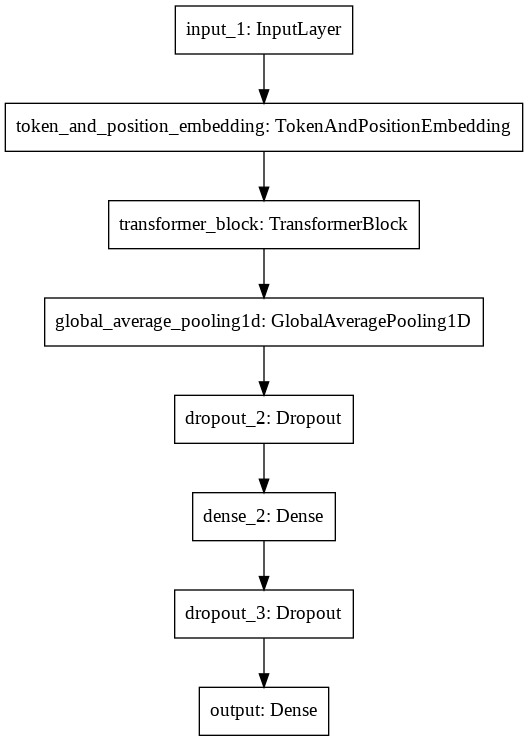

In [44]:
tf.keras.utils.plot_model(
    model1, to_file='model1.png',
)

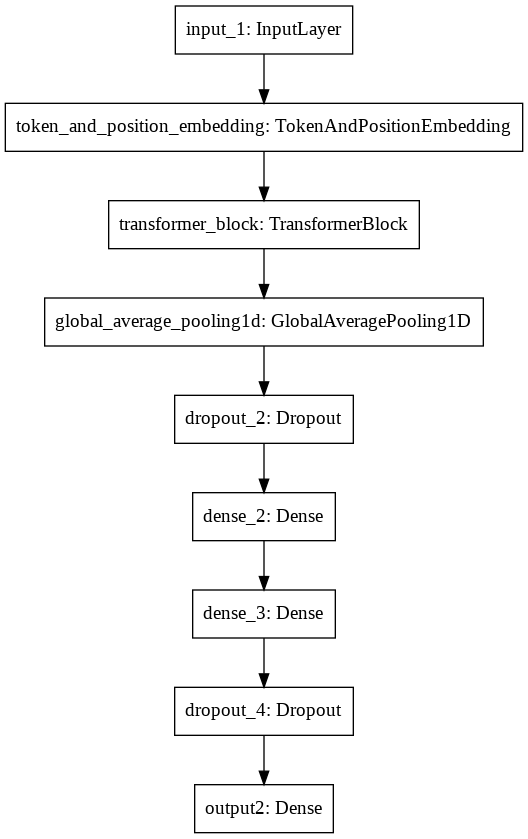

In [45]:
tf.keras.utils.plot_model(
    model2, to_file='model2.png',
)

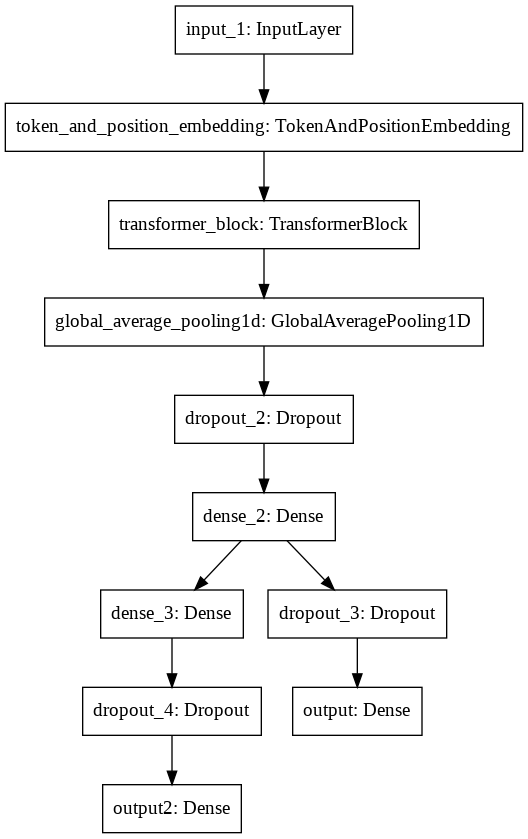

In [46]:
tf.keras.utils.plot_model(
    combined_model, to_file='combined_model.png',
)

In [47]:
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [48]:
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [49]:
x_train1 = tf.keras.preprocessing.sequence.pad_sequences(x1, maxlen=maxlen)

In [50]:
x_train2 = tf.keras.preprocessing.sequence.pad_sequences(x2, maxlen=maxlen)

In [51]:
import random
for i in range(10):
    x = random.random()
    if(x<0.5):
        print("Model 1")
        model1.fit(x_train1, y1, batch_size = 128, epochs=1, verbose=1, validation_split = 0.1,)
    else:
        print("Model 2")
        model2.fit(x_train2, y2, batch_size=128, epochs=1, verbose=1, validation_split = 0.1, )

Model 1
176/176 [==============================] - 37s 199ms/step - loss: 0.7009 - accuracy: 0.5020 - val_loss: 0.6888 - val_accuracy: 0.5100
Model 1
176/176 [==============================] - 35s 197ms/step - loss: 0.5708 - accuracy: 0.6676 - val_loss: 0.3320 - val_accuracy: 0.8528
Model 2
352/352 [==============================] - 71s 197ms/step - loss: 0.2906 - accuracy: 0.2606 - val_loss: 0.0783 - val_accuracy: 0.9950
Model 2
352/352 [==============================] - 70s 198ms/step - loss: 0.0820 - accuracy: 0.7759 - val_loss: 0.0696 - val_accuracy: 0.9950
Model 1
176/176 [==============================] - 35s 199ms/step - loss: 0.5298 - accuracy: 0.7523 - val_loss: 0.3620 - val_accuracy: 0.8344
Model 2
352/352 [==============================] - 70s 200ms/step - loss: 0.0811 - accuracy: 0.8691 - val_loss: 0.0695 - val_accuracy: 0.9950
Model 1
176/176 [==============================] - 35s 200ms/step - loss: 0.4709 - accuracy: 0.7832 - val_loss: 0.3354 - val_accuracy: 0.8536
Model 